<a href="https://colab.research.google.com/github/bumbum2403/AtlantaSys/blob/main/Speech_Verification_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone dataset
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git
%cd free-spoken-digit-dataset/recordings


Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4260, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 4260 (delta 25), reused 8 (delta 8), pack-reused 4212 (from 1)
Receiving objects: 100% (4260/4260), 30.38 MiB | 30.21 MiB/s, done.
Resolving deltas: 100% (129/129), done.
/content/free-spoken-digit-dataset/recordings


In [2]:
import os
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load WAV files and extract MFCCs
def extract_mfcc(file_path, max_len=11, n_mfcc=40):
    audio, sr = librosa.load(file_path, sr=8000)
    mfcc = librosa.feature.mfcc(audio, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc


In [3]:
import os
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load WAV files and extract MFCCs
def extract_mfcc(file_path, max_len=11, n_mfcc=40, sr_target=8000):
    audio, sr = librosa.load(file_path, sr=sr_target)

    # Choose n_fft adaptively: 512 for short clips, else 1024
    n_fft = 512 if len(audio) < 1024 else 1024
    hop = n_fft // 2           # 50 % overlap

    mfcc = librosa.feature.mfcc(
        y=audio,
        sr=sr,
        n_mfcc=n_mfcc,
        n_fft=n_fft,
        hop_length=hop
    )

    # Pad/trim to fixed time dimension
    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0,0), (0, max_len - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc


In [4]:
# Collect all files
all_files = [f for f in os.listdir('.') if f.endswith('.wav')]
print(f"{len(all_files)} audio files found.")

# Limit to 3 speakers for simplicity
target_speakers = ['jackson', 'nicolas', 'theo']
X, y = [], []

for file in all_files:
    # Split the filename to get the speaker name
    speaker = file.split('_')[1]
    # Process only files from target speakers
    if speaker in target_speakers:
        # Extract MFCC features
        mfcc = extract_mfcc(file)
        # Append features and speaker label to lists
        X.append(mfcc)
        y.append(speaker)

# Convert lists to numpy arrays
X = np.array(X)[..., np.newaxis]  # Add channel dimension for compatibility with some models
y = np.array(y)

# Encode speaker labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

3000 audio files found.


In [5]:
print("Speaker Lables :  ", y_enc.shape)
print("MFCC features : " , X.shape)


Speaker Lables :   (1500,)
MFCC features :  (1500, 40, 11, 1)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

# Define embedding model (no softmax at end)
def build_embedding_model(input_shape=(40, 11, 1), emb_dim=128):
    inp = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu')(inp)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dense(emb_dim)(x)  # Speaker embedding (no activation)
    model = Model(inputs=inp, outputs=x)
    return model

embedding_model = build_embedding_model()
embedding_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40, 11, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 38, 9, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 2, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,480 (330.00 KB)

 Trainable params: 84,480 (330.00 KB)

 Non-trainable params: 0 (0.00 B)

Build and Train the Speaker Classifier

In [7]:
from tensorflow.keras.layers import Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# One-hot encode labels
y_cat = to_categorical(y_enc, num_classes=3)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Freeze embedding model (optional: can fine-tune too)
# for layer in embedding_model.layers:
#     layer.trainable = False

# Add softmax head on top of embeddings
x = embedding_model.output
x = Dense(3, activation='softmax')(x)
classifier_model = Model(inputs=embedding_model.input, outputs=x)

# Compile & train
classifier_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = classifier_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6876 - loss: 2.6374 - val_accuracy: 0.9600 - val_loss: 0.0911
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9940 - loss: 0.0221 - val_accuracy: 1.0000 - val_loss: 0.0072
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0041 - val_accuracy: 0.9967 - val_loss: 0.0064
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9967 - val_loss: 0.0062
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.3415e-04 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.2009e-04 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.1060e-04 - val_accuracy: 1.000

SPEAKER VERIFICATION USING COSINE SIMILARITY

In [8]:
#CODE FOR VERIFICATION

from sklearn.metrics.pairwise import cosine_similarity

# Function: Get embedding from .wav file
def get_embedding(file_path):
    mfcc = extract_mfcc(file_path)
    mfcc = mfcc[np.newaxis, ..., np.newaxis]  # Add batch & channel dims
    emb = embedding_model.predict(mfcc)[0]    # Shape: (128,)
    return emb

# Cosine similarity between two embeddings
def is_same_speaker(embedding1, embedding2, threshold=0.75):
    sim = cosine_similarity([embedding1], [embedding2])[0][0]
    print(f"Cosine Similarity: {sim:.4f}")
    return sim >= threshold


In [9]:
#example usage:

# Example: Compare Jackson (same speaker)
ref_file = '0_jackson_0.wav'
test_file_same = '1_jackson_4.wav'
test_file_diff = '1_theo_0.wav'

# Get embeddings
ref_emb = get_embedding(ref_file)
test_emb_same = get_embedding(test_file_same)
test_emb_diff = get_embedding(test_file_diff)

# Verify
print("\n[+] SAME SPEAKER:")
print(is_same_speaker(ref_emb, test_emb_same))  # Expect: True

print("\n[+] DIFFERENT SPEAKER:")
print(is_same_speaker(ref_emb, test_emb_diff))  # Expect: False



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

[+] SAME SPEAKER:
Cosine Similarity: 0.9272
True

[+] DIFFERENT SPEAKER:
Cosine Similarity: 0.2597
False


In [10]:
def pretty_verify(ref_path, test_path, threshold=0.75):
    print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    print(f"🔊 Reference Audio : {ref_path}")
    print(f"🎤 Test Audio      : {test_path}")

    ref_emb = get_embedding(ref_path)
    test_emb = get_embedding(test_path)

    similarity = cosine_similarity([ref_emb], [test_emb])[0][0]
    verdict = "✅ SAME SPEAKER" if similarity >= threshold else "❌ DIFFERENT SPEAKER"

    print(f"Cosine Similarity: {similarity:.4f}")
    print(f" Threshold: {threshold:.2f}")
    print(f" Prediction: {verdict}")
    print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n")

# 🔁 Batch of test cases
test_cases = [
    ('0_jackson_0.wav', '1_jackson_2.wav'),  # ✅ same
    ('0_jackson_0.wav', '2_jackson_9.wav'),  # ✅ same
    ('0_jackson_0.wav', '3_theo_3.wav'),     # ❌ different
    ('1_theo_2.wav', '2_theo_9.wav'),        # ✅ same
    ('2_nicolas_1.wav', '3_jackson_0.wav'),  # ❌ different
    ('3_nicolas_7.wav', '4_nicolas_3.wav'),  # ✅ same
    ('1_theo_2.wav', '0_nicolas_1.wav'),     # ❌ different
]

# 🧪 Run all cases
for ref, test in test_cases:
    pretty_verify(ref, test)


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔊 Reference Audio : 0_jackson_0.wav
🎤 Test Audio      : 1_jackson_2.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Cosine Similarity: 0.8894
 Threshold: 0.75
 Prediction: ✅ SAME SPEAKER
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔊 Reference Audio : 0_jackson_0.wav
🎤 Test Audio      : 2_jackson_9.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Cosine Similarity: 0.9069
 Threshold: 0.75
 Prediction: ✅ SAME SPEAKER
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔊 Reference Audio : 0_jackson_0.wav
🎤 Test Audio      : 3_theo_3.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Cosine Similarity: 0.3628
 Threshold: 0.75
 Prediction: ❌ DIFFERENT SPEAKER
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔊 Reference Audio : 1_theo_2.wav
🎤 Test Audio      : 2_theo_9.wav
1/1 ━━

EVALUATION AND TESTING

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1-score: 1.000


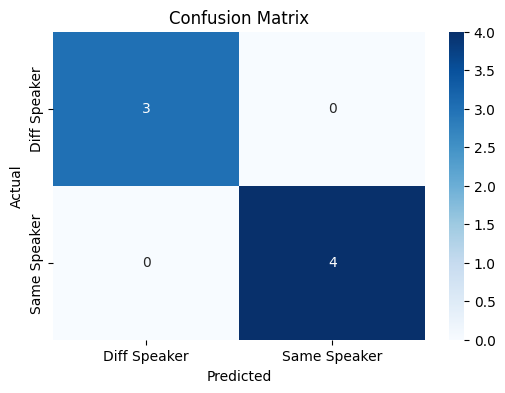

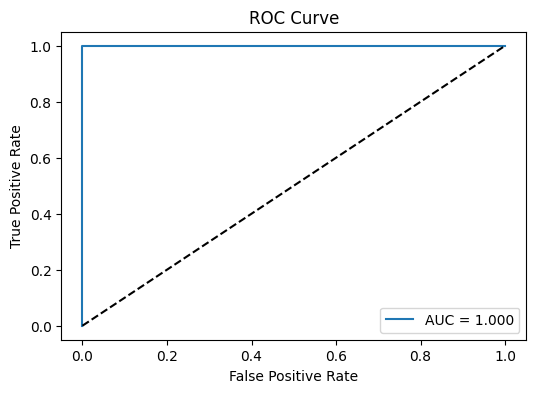

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns

# Define test pairs and ground truth labels (1=same speaker, 0=different)
test_pairs = [
    ('0_jackson_0.wav', '1_jackson_2.wav', 1),
    ('0_jackson_0.wav', '2_jackson_9.wav', 1),
    ('0_jackson_0.wav', '3_theo_3.wav', 0),
    ('1_theo_2.wav', '2_theo_9.wav', 1),
    ('2_nicolas_1.wav', '3_jackson_0.wav', 0),
    ('3_nicolas_7.wav', '4_nicolas_3.wav', 1),
    ('1_theo_2.wav', '0_nicolas_1.wav', 0),
]

threshold = 0.75

y_true = []
y_pred = []
similarities = []

for ref_file, test_file, label in test_pairs:
    ref_emb = get_embedding(ref_file)
    test_emb = get_embedding(test_file)
    sim = cosine_similarity([ref_emb], [test_emb])[0][0]

    pred = 1 if sim >= threshold else 0

    y_true.append(label)
    y_pred.append(pred)
    similarities.append(sim)

# Compute Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

# Confusion Matrix Plot
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Diff Speaker', 'Same Speaker'], yticklabels=['Diff Speaker', 'Same Speaker'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve & AUC
fpr, tpr, _ = roc_curve(y_true, similarities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

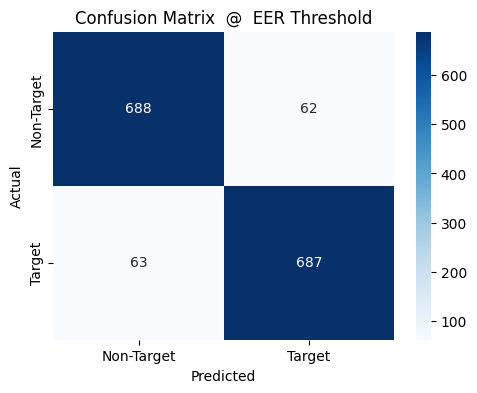

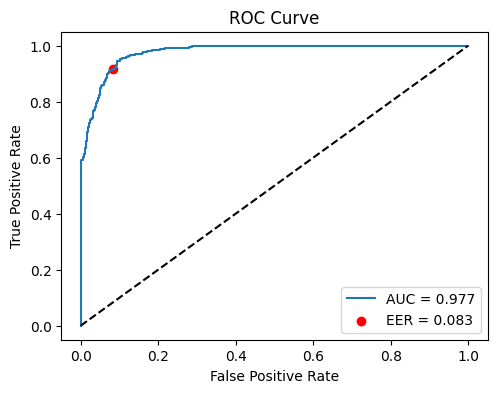

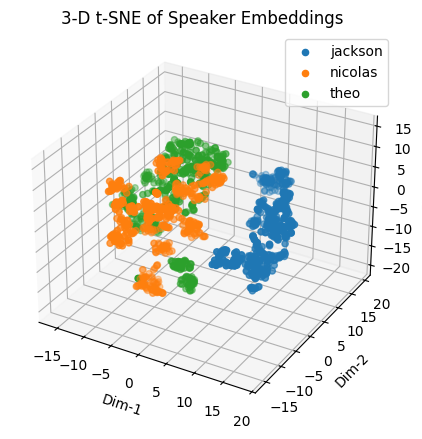

In [11]:
# --------------------------------------------
# Evaluation & Visualisation Cell
# --------------------------------------------
import itertools, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from mpl_toolkits.mplot3d import Axes3D           # noqa: F401 (for 3-D plot)
from sklearn.metrics import (confusion_matrix, roc_curve, auc,
                             precision_score, recall_score, f1_score,
                             accuracy_score)

# ――― 0. CACHE EMBEDDINGS FOR TARGET SPEAKERS ―――
embedding_dict = {}
for wav in all_files:
    spk = wav.split('_')[1]
    if spk in target_speakers:                # only our 3 speakers
        embedding_dict[wav] = get_embedding(wav)

files = list(embedding_dict.keys())

# ――― 1. BUILD PAIR LIST (balanced & capped) ―――
same_pairs, diff_pairs = [], []
for f1, f2 in itertools.combinations(files, 2):
    s1, s2 = f1.split('_')[1], f2.split('_')[1]
    pair = (f1, f2, 1 if s1 == s2 else 0)
    (same_pairs if s1 == s2 else diff_pairs).append(pair)

cap_per_class = 750                     # cap for speed (≈ 1 500 pairs total)
same_pairs  = same_pairs [:cap_per_class]
diff_pairs  = diff_pairs [:cap_per_class]
pair_list   = same_pairs + diff_pairs
np.random.shuffle(pair_list)

# ――― 2. COSINE SIMILARITIES USING CACHED EMBEDDINGS ―――
sims, y_true = [], []
for f_ref, f_test, lab in pair_list:
    emb1 = embedding_dict[f_ref]
    emb2 = embedding_dict[f_test]
    sims.append(cosine_similarity([emb1], [emb2])[0][0])
    y_true.append(lab)

sims = np.array(sims)
y_true = np.array(y_true)

# ――― 3. EER THRESHOLD ―――
fpr, tpr, thr = roc_curve(y_true, sims)
fnr          = 1 - tpr
eer_idx      = np.nanargmin(np.abs(fnr - fpr))
eer_threshold = thr[eer_idx]
eer           = fpr[eer_idx]           # ≈ fnr[eer_idx]

print(f"\nEqual-Error-Rate (EER): {eer:.3f}  at threshold {eer_threshold:.3f}")

# Predictions with EER threshold
y_pred = (sims >= eer_threshold).astype(int)

# ――― 4. METRICS & CONFUSION MATRIX ―――
acc  = accuracy_score (y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score   (y_true, y_pred)
f1   = f1_score       (y_true, y_pred)

print(f"Accuracy : {acc :.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec :.3f}")
print(f"F1-score : {f1  :.3f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5.5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Target','Target'],
            yticklabels=['Non-Target','Target'])
plt.title("Confusion Matrix  @  EER Threshold")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

# ――― 5. ROC CURVE ―――
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5.5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.scatter(fpr[eer_idx], tpr[eer_idx], color='red', label=f"EER = {eer:.3f}")
plt.title("ROC Curve"); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.show()

# ――― 6. 3-D t-SNE EMBEDDING VISUALISATION ―――
from sklearn.manifold import TSNE                           # swap with umap for faster
emb_list = list(embedding_dict.values())
lab_list = [wav.split('_')[1] for wav in embedding_dict.keys()]

emb_3d = TSNE(n_components=3, random_state=42).fit_transform(np.vstack(emb_list))

fig = plt.figure(figsize=(7,5))
ax  = fig.add_subplot(111, projection='3d')
for spk in target_speakers:
    idx = [i for i,l in enumerate(lab_list) if l == spk]
    ax.scatter(emb_3d[idx,0], emb_3d[idx,1], emb_3d[idx,2], label=spk, s=20)
ax.set_title("3-D t-SNE of Speaker Embeddings")
ax.set_xlabel("Dim-1"); ax.set_ylabel("Dim-2"); ax.set_zlabel("Dim-3")
ax.legend(); plt.show()
